In [3]:
import os
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import random
seed = 0
np.random.seed(seed)
random.seed(seed)
import scipy.sparse as sp
import time
from banksy_utils.filter_utils import filter_cells
from banksy_utils.load_data import load_adata
from banksy_utils.filter_utils import normalize_total, filter_hvg
from banksy.main import median_dist_to_nearest_neighbour
from banksy.initialize_banksy import initialize_banksy
from banksy.main import concatenate_all
from banksy.embed_banksy import generate_banksy_matrix
from banksy_utils.umap_pca import pca_umap
from banksy.cluster_methods import run_Leiden_partition
from banksy.plot_banksy import plot_results
from memory_profiler import memory_usage
import torch

In [4]:
max_m = 1
nbr_weight_decay = "scaled_gaussian"
lambda_list = [0.8]
pca_dims = [20]
n_neighbors=10

In [5]:
adata=sc.read_h5ad('/home/dbj/SpaLP/Tutorialdata/CosMxMouseBrain.h5ad')
adata.obs["spatial_x"] = adata.obsm["spatial"][:, 0]
adata.obs["spatial_y"] = adata.obsm["spatial"][:, 1]
adata

AnnData object with n_obs × n_vars = 48180 × 950
    obs: 'spatialClusteringAssignments', 'spatial_x', 'spatial_y'
    uns: 'RNA_nbclust_clusters_colors', 'spatialClusteringAssignments_colors'
    obsm: 'spatial'

In [6]:
adata_new = sc.AnnData(sp.csr_matrix((adata.shape[0], adata.shape[1]),dtype=np.float32))
adata_new.var_names = adata.var_names
adata_new.obs_names = adata.obs_names
adata_new.obsm["spatial"] = adata.obsm["spatial"]

In [7]:
adata_new.obs['spatialClusteringAssignments']=adata.obs['spatialClusteringAssignments']

In [8]:
device_idx=0
def measure_resources(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        mem_usage = memory_usage((func, args, kwargs), max_usage=True) / 1024
        end_time = time.time()
        execution_time = end_time - start_time
        minutes = execution_time // 60
        seconds = execution_time % 60
        if torch.cuda.is_available():
            device = torch.device(f"cuda:{device_idx}")
            allocated = torch.cuda.memory_allocated(device) / (1024 ** 3) 
            cached = torch.cuda.memory_reserved(device) / (1024 ** 3)
        else:
            allocated = cached = 0

        print(f"Function '{func.__name__}' executed in {minutes} minutes and {seconds:.4f} seconds.")
        print(f"Memory usage: {mem_usage:.2f} GB")
        print(f"GPU memory allocated: {allocated:.2f} GB")
        print(f"GPU memory cached: {cached:.2f} GB")

    return wrapper

In [9]:
@measure_resources
def run_pipeline():
    banksy_dict = initialize_banksy(
        adata,
        ("spatial_x", "spatial_y", "spatial"),
        n_neighbors,
        nbr_weight_decay=nbr_weight_decay,
        max_m=max_m,
        plt_edge_hist=False,
        plt_nbr_weights=False,
        plt_agf_angles=False,
        plt_theta=False
    )
    
    banksy_dict, banksy_matrix = generate_banksy_matrix(adata,banksy_dict,lambda_list,max_m)
    pca_umap(banksy_dict,pca_dims=pca_dims,add_umap=True,plt_remaining_var=False)
    adata.obsm['banksy'] = banksy_dict[nbr_weight_decay][lambda_list[0]]["adata"].obsm["reduced_pc_20"]
    adata_new.obsm['banksy'] = adata.obsm['banksy']

In [10]:
run_pipeline()


Median distance to closest cell = 0.013698934265117051

---- Ran median_dist_to_nearest_neighbour in 0.14 s ----

---- Ran generate_spatial_distance_graph in 0.26 s ----

---- Ran row_normalize in 0.13 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 1.33 s ----

---- Ran generate_spatial_distance_graph in 0.40 s ----

---- Ran theta_from_spatial_graph in 0.31 s ----

---- Ran row_normalize in 0.13 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 1.80 s ----

Runtime Feb-07-2026-14-25

950 genes to be analysed:
Gene List:
Index(['6330403K07Rik', 'Abca2', 'Abi1', 'Abi2', 'Abl1', 'Ace2', 'Acer3',
       'Acta2', 'Ada', 'Adam10',
       ...
       'Xcl1', 'Xpo1', 'Ybx1', 'Ywhag', 'Ywhaq', 'Ywhaz', 'Zbtb20', 'Zeb1',
       'Zfyve16', 'Zwint'],
      dtype='object', length=950)

Decay Type: scaled_gaussian
Weights Object: {'weights': {0: <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 481800 stored elements and shape (48180, 48180)>, 1: <Compressed Sparse Row sp

In [11]:
@measure_resources
def run_leiden(adata):
    sc.pp.neighbors(adata_new, use_rep='banksy')
    sc.tl.leiden(adata_new, random_state=2024, resolution=0.8,key_added='BANKSY_leiden')
run_leiden(adata=adata)

Function 'run_leiden' executed in 0.0 minutes and 16.7662 seconds.
Memory usage: 2.89 GB
GPU memory allocated: 0.00 GB
GPU memory cached: 0.00 GB


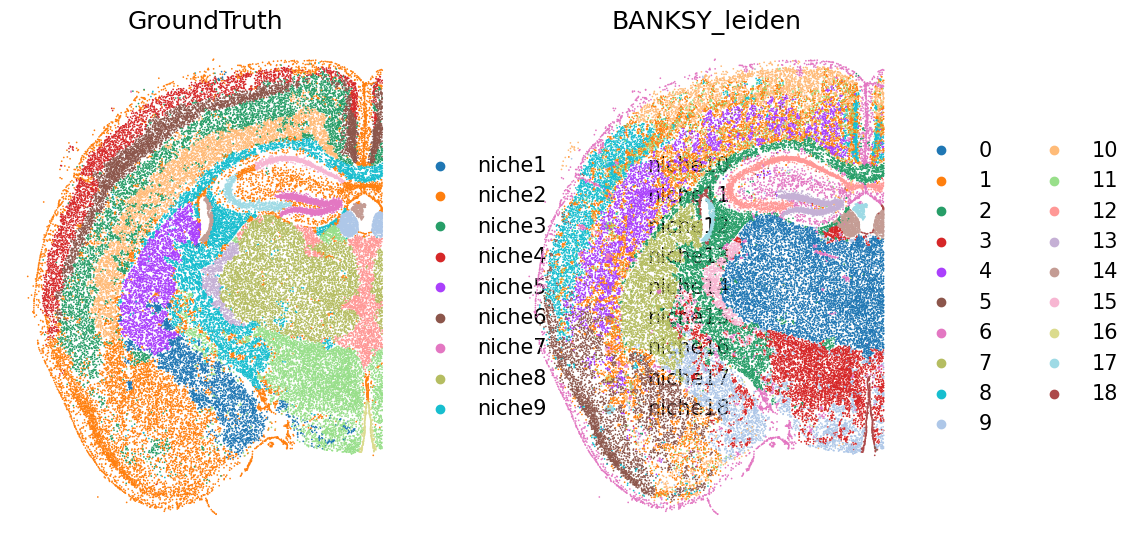

In [12]:
import matplotlib.pyplot as plt
import copy
from scanpy.plotting import palettes
plt.rcParams['figure.figsize'] = (5,6.5)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata_new, basis="spatial",s=6, color=['spatialClusteringAssignments','BANKSY_leiden'],colorbar_loc=None,title='GroundTruth',frameon=False,palette=palettes.default_20)

In [13]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata_new.obs['spatialClusteringAssignments'])
cluster_labels = np.array(adata_new.obs['BANKSY_leiden'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.42354403366227505
NMI: 0.6119823258092
AMI: 0.611508751600703
FMI: 0.47432481090790185
V-Measure: 0.6119823258092
Homogeneity: 0.6288465678999358


In [14]:
from sklearn.cluster import KMeans
@measure_resources
def run_kmeans(adata):
    kmeans = KMeans(n_clusters=19, random_state=2024) 
    labels = kmeans.fit_predict(adata.obsm['banksy'])
    adata.obs['BANKSY_kmeans']=labels.astype(str)
run_kmeans(adata=adata)

Function 'run_kmeans' executed in 0.0 minutes and 2.6190 seconds.
Memory usage: 2.75 GB
GPU memory allocated: 0.00 GB
GPU memory cached: 0.00 GB


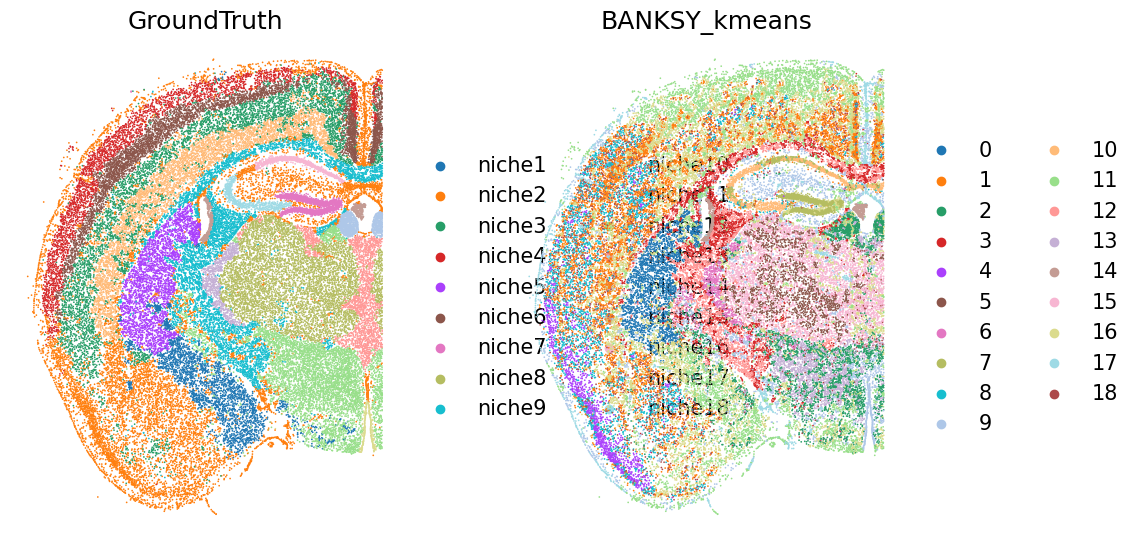

In [15]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,6.5)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata, basis="spatial",s=6, color=['spatialClusteringAssignments','BANKSY_kmeans'],colorbar_loc=None,title='GroundTruth',frameon=False,palette=palettes.default_20)

In [16]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata.obs['spatialClusteringAssignments'])
cluster_labels = np.array(adata.obs['BANKSY_kmeans'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.18106515536123874
NMI: 0.4189216745659976
AMI: 0.41821377201826176
FMI: 0.25272905280585
V-Measure: 0.4189216745659976
Homogeneity: 0.43065704733273136


In [17]:
adata_new.write_h5ad('/home/dbj/STAGATE/BANKSY_CosMx_mousebrain_k_10.h5ad',compression='gzip')